# Fine Tune
- RoBERTa
- No need for inference speed up using distil bert since dataset is very small
- Hyperparameter tuning using huggingfaces hyperparameter search
- group k fold cross validation for prediction

## Several conditions:
- (spell corrected and) expanded prompts
- raw conversational part


In [1]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")


Using GPU: NVIDIA L4


In [2]:
#import sqlite3
import pandas as pd
from google.colab import files

files.upload()


#conn  = sqlite3.connect('../../giicg.db')
#all_prompts = pd.read_sql("Select * from expanded_roberta_prompts", conn)
#conn.close()
all_prompts = pd.read_csv('expanded_roberta_prompts.csv')


Saving expanded_roberta_prompts.csv to expanded_roberta_prompts.csv


## Check data

In [3]:
users_per_gender = all_prompts.groupby('gender')['user_id'].nunique().reset_index(name='num_users')
users_per_gender

,gender,num_users
0,Man (cisgender),15
1,Woman (cisgender),13


In [4]:
messages_per_user = all_prompts.groupby('user_id')['message_id'].nunique().reset_index(name='num_messages')
messages_per_user

,user_id,num_messages
0,6,9
1,8,2
2,11,11
3,15,3
4,16,25
5,25,4
6,28,22
7,29,2
8,31,5
9,34,66


## Set up Model

In [5]:
import json
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, precision_recall_fscore_support


files.upload()

with open("label2id.json", "r") as f:
    label2id = json.load(f)


model_name = "roberta-base"

new_special_tokens = ["[URL]", "[CODE]", "[ID]", "[OTHER]", "[INFO]"]

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.add_special_tokens({"additional_special_tokens": new_special_tokens})

num_labels = len(label2id)

def model_init():
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels,
    )
    model.resize_token_embeddings(len(tokenizer))
    return model

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize_function(examples):
    return tokenizer(
        examples["conversational"],
        truncation=True,
        padding=False # padding is handled in the data collator
    )

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    acc = accuracy_score(labels, preds)

    # Get per-class metrics & support
    precision, recall, f1, support = precision_recall_fscore_support(labels, preds, average=None)
    precision_w = precision_recall_fscore_support(labels, preds, average='weighted')[0]
    recall_w    = precision_recall_fscore_support(labels, preds, average='weighted')[1]
    f1_w        = precision_recall_fscore_support(labels, preds, average='weighted')[2]

    num_classes = len(precision)

    metrics = {
        'accuracy': acc,
        'precision_weighted': precision_w,
        'recall_weighted': recall_w,
        'f1_weighted': f1_w,
    }

    for i in range(num_classes):
        metrics[f'precision_class_{i}'] = precision[i]
        metrics[f'recall_class_{i}'] = recall[i]
        metrics[f'f1_class_{i}'] = f1[i]
        metrics[f'support_class_{i}'] = support[i]

    return metrics



Saving label2id.json to label2id.json


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

## Check max sample size

In [21]:
texts = all_prompts['conversational'].tolist()

token_counts = [len(tokenizer.encode(text, add_special_tokens=True, truncation=True)) for text in texts]

max_tokens = max(token_counts)
min_tokens = min(token_counts)
avg_tokens = sum(token_counts) / len(token_counts)

print(f"Max tokens: {max_tokens}")
print(f"Min tokens: {min_tokens}")


Max tokens: 512
Min tokens: 4


# ECE


In [9]:

def expected_calibration_error(y_true, y_prob, n_bins=15, strategy="uniform"):
    """
    Compute Expected Calibration Error (ECE).
    Parameters:
      y_true: array-like of shape (n_samples,), binary labels {0,1}
      y_prob: array-like of shape (n_samples,), predicted probability for the positive class
      n_bins: number of bins
      strategy: "uniform" (equal-width bins) or "quantile" (equal-size bins)
    Returns:
      float ECE
    """
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob).astype(float)

    if strategy == "uniform":
        bins = np.linspace(0.0, 1.0, n_bins + 1)
    elif strategy == "quantile":
        # Quantile binning based on predicted probabilities
        bins = np.quantile(y_prob, np.linspace(0.0, 1.0, n_bins + 1))
        # Ensure coverage of [0,1]
        bins[0], bins[-1] = 0.0, 1.0
        # Handle potential identical bin edges due to ties
        bins = np.unique(bins)
        # In rare cases unique quantiles < n_bins+1; fall back to uniform
        if bins.size < 3:
            bins = np.linspace(0.0, 1.0, n_bins + 1)
    else:
        raise ValueError("strategy must be 'uniform' or 'quantile'")

    # Assign each prob to a bin index in [0, n_bins-1]
    bin_indices = np.digitize(y_prob, bins[1:-1], right=True)

    ece = 0.0
    N = y_true.size
    for b in range(len(bins) - 1):
        mask = (bin_indices == b)
        n_b = np.sum(mask)
        if n_b == 0:
            continue
        acc_b = np.mean(y_true[mask])
        conf_b = np.mean(y_prob[mask])
        ece += (n_b / N) * abs(acc_b - conf_b)
    return float(ece)

## Cross Validation

- selected hyperparameters: lr 3.2e-5, batchsizes 8, epochs 5

In [10]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset
from sklearn.model_selection import GroupKFold
from scipy.special import softmax
import numpy as np


groups = all_prompts['user_id'].values
texts = all_prompts['conversational'].tolist()
labels = all_prompts['label'].tolist()
n_splits = 5  # e.g. 5-fold CV

gkf = GroupKFold(n_splits=n_splits)

all_results = []
all_probs = []
all_true = []

for fold, (train_idx, val_idx) in enumerate(gkf.split(texts, labels, groups)):
    print(f"Fold {fold + 1}")

    train_prompts = all_prompts.iloc[train_idx]
    val_prompts = all_prompts.iloc[val_idx]

    train_dataset = Dataset.from_pandas(train_prompts[['conversational', 'label']])
    val_dataset = Dataset.from_pandas(val_prompts[['conversational', 'label']])

    train_dataset = train_dataset.map(tokenize_function, batched=True)
    val_dataset = val_dataset.map(tokenize_function, batched=True)

    # Set up Trainer with model/tokenizer/data_collator as before
    trainer = Trainer(
        model_init=model_init,
        args=TrainingArguments(
            output_dir=f"./finetune_MASKED/cross_validation/fold_{fold+1}_results",
            eval_strategy="epoch",
            save_strategy="epoch",
            logging_dir=f"./fold_{fold+1}_logs",
            per_device_train_batch_size=8,
            per_device_eval_batch_size=8,
            num_train_epochs=5,
            learning_rate=1.2e-5,
            load_best_model_at_end=True,
            metric_for_best_model="accuracy",
            logging_steps=50,
            logging_strategy="steps",
            report_to="none",
        ),
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
        compute_metrics=compute_metrics,
    )

    trainer.train()
    eval_metrics = trainer.evaluate()
    print(f"Fold {fold + 1} metrics:", eval_metrics)

    # Get predictions on validation set
    outputs = trainer.predict(val_dataset)
    y_true = outputs.label_ids

    # If binary classification, logits.shape = (n, 2) for [class0, class1]
    # Prob: use softmax for multiclass or sigmoid for single logit
    y_logits = outputs.predictions

    # For binary classification with two logits (per sample)
    y_prob = softmax(y_logits, axis=1)[:, 1]

    # Save for this fold
    all_probs.append(y_prob)
    all_true.append(y_true)

    all_results.append(eval_metrics)

print(all_results)

pooled_true = np.concatenate(all_true)
pooled_probs = np.concatenate(all_probs)
pooled_ece = expected_calibration_error(pooled_true, pooled_probs)
print("Pooled ECE across all folds:", pooled_ece)





Fold 1


Map:   0%|          | 0/429 [00:00<?, ? examples/s]

Map:   0%|          | 0/107 [00:00<?, ? examples/s]

/tmp/ipython-input-3962966348.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Weighted,Recall Weighted,F1 Weighted,Precision Class 0,Recall Class 0,F1 Class 0,Support Class 0,Precision Class 1,Recall Class 1,F1 Class 1,Support Class 1
1,0.678600,1.001393,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,0.000000,0.000000,0.000000,0.000000
2,0.622500,0.897362,0.579439,1.000000,0.579439,0.733728,1.000000,0.579439,0.733728,107,0.000000,0.000000,0.000000,0
3,0.542000,0.592997,0.757009,1.000000,0.757009,0.861702,1.000000,0.757009,0.861702,107,0.000000,0.000000,0.000000,0
4,0.422900,0.846370,0.616822,1.000000,0.616822,0.763006,1.000000,0.616822,0.763006,107,0.000000,0.000000,0.000000,0
5,0.318300,0.884513,0.626168,1.000000,0.626168,0.770115,1.000000,0.626168,0.770115,107,0.000000,0.000000,0.000000,0


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

Fold 1 metrics: {'eval_loss': 0.5929972529411316, 'eval_accuracy': 0.7570093457943925, 'eval_precision_weighted': 1.0, 'eval_recall_weighted': 0.7570093457943925, 'eval_f1_weighted': 0.8617021276595743, 'eval_precision_class_0': 1.0, 'eval_recall_class_0': 0.7570093457943925, 'eval_f1_class_0': 0.8617021276595744, 'eval_support_class_0': 107, 'eval_precision_class_1': 0.0, 'eval_recall_class_1': 0.0, 'eval_f1_class_1': 0.0, 'eval_support_class_1': 0, 'eval_runtime': 0.1913, 'eval_samples_per_second': 559.206, 'eval_steps_per_second': 73.167, 'epoch': 5.0}


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.p

Fold 2


Map:   0%|          | 0/428 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

/tmp/ipython-input-3962966348.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Weighted,Recall Weighted,F1 Weighted,Precision Class 0,Recall Class 0,F1 Class 0,Support Class 0,Precision Class 1,Recall Class 1,F1 Class 1,Support Class 1
1,0.686500,0.947001,0.120370,0.014489,0.120370,0.025865,0.000000,0.000000,0.000000,95,0.120370,1.000000,0.214876,13
2,0.588300,0.755954,0.685185,0.869602,0.685185,0.739598,0.955224,0.673684,0.790123,95,0.243902,0.769231,0.370370,13
3,0.463300,0.873302,0.611111,0.859468,0.611111,0.678560,0.949153,0.589474,0.727273,95,0.204082,0.769231,0.322581,13
4,0.368500,0.867834,0.657407,0.880039,0.657407,0.717212,0.967742,0.631579,0.764331,95,0.239130,0.846154,0.372881,13
5,0.279800,1.059506,0.592593,0.872626,0.592593,0.661728,0.963636,0.557895,0.706667,95,0.207547,0.846154,0.333333,13


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Fold 2 metrics: {'eval_loss': 0.7559544444084167, 'eval_accuracy': 0.6851851851851852, 'eval_precision_weighted': 0.8696018552225323, 'eval_recall_weighted': 0.6851851851851852, 'eval_f1_weighted': 0.7395976223136715, 'eval_precision_class_0': 0.9552238805970149, 'eval_recall_class_0': 0.6736842105263158, 'eval_f1_class_0': 0.7901234567901234, 'eval_support_class_0': 95, 'eval_precision_class_1': 0.24390243902439024, 'eval_recall_class_1': 0.7692307692307693, 'eval_f1_class_1': 0.37037037037037035, 'eval_support_class_1': 13, 'eval_runtime': 0.3793, 'eval_samples_per_second': 284.699, 'eval_steps_per_second': 36.905, 'epoch': 5.0}
Fold 3


Map:   0%|          | 0/429 [00:00<?, ? examples/s]

Map:   0%|          | 0/107 [00:00<?, ? examples/s]

/tmp/ipython-input-3962966348.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Weighted,Recall Weighted,F1 Weighted,Precision Class 0,Recall Class 0,F1 Class 0,Support Class 0,Precision Class 1,Recall Class 1,F1 Class 1,Support Class 1
1,0.645700,1.253425,0.028037,0.000786,0.028037,0.001529,0.028037,1.000000,0.054545,3,0.000000,0.000000,0.000000,104
2,0.576000,1.427805,0.112150,0.972821,0.112150,0.156491,0.030612,1.000000,0.059406,3,1.000000,0.086538,0.159292,104
3,0.492600,1.517315,0.280374,0.939166,0.280374,0.410632,0.025641,0.666667,0.049383,3,0.965517,0.269231,0.421053,104
4,0.376100,1.510599,0.308411,0.942336,0.308411,0.444538,0.026667,0.666667,0.051282,3,0.968750,0.298077,0.455882,104
5,0.310000,1.715042,0.261682,0.936665,0.261682,0.387168,0.025000,0.666667,0.048193,3,0.962963,0.250000,0.396947,104


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Fold 3 metrics: {'eval_loss': 1.5105985403060913, 'eval_accuracy': 0.308411214953271, 'eval_precision_weighted': 0.9423364485981308, 'eval_recall_weighted': 0.308411214953271, 'eval_f1_weighted': 0.44453841924979914, 'eval_precision_class_0': 0.02666666666666667, 'eval_recall_class_0': 0.6666666666666666, 'eval_f1_class_0': 0.05128205128205128, 'eval_support_class_0': 3, 'eval_precision_class_1': 0.96875, 'eval_recall_class_1': 0.2980769230769231, 'eval_f1_class_1': 0.45588235294117646, 'eval_support_class_1': 104, 'eval_runtime': 0.3135, 'eval_samples_per_second': 341.319, 'eval_steps_per_second': 44.659, 'epoch': 5.0}
Fold 4


Map:   0%|          | 0/428 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

/tmp/ipython-input-3962966348.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Weighted,Recall Weighted,F1 Weighted,Precision Class 0,Recall Class 0,F1 Class 0,Support Class 0,Precision Class 1,Recall Class 1,F1 Class 1,Support Class 1
1,0.681100,0.671133,0.592593,0.629897,0.592593,0.598229,0.725490,0.552239,0.627119,67,0.473684,0.658537,0.551020,41
2,0.604100,0.625538,0.666667,0.658839,0.666667,0.660652,0.712329,0.776119,0.742857,67,0.571429,0.487805,0.526316,41
3,0.469500,0.662536,0.666667,0.666667,0.666667,0.666667,0.731343,0.731343,0.731343,67,0.560976,0.560976,0.560976,41
4,0.382700,0.754337,0.657407,0.655828,0.657407,0.656561,0.720588,0.731343,0.725926,67,0.550000,0.536585,0.543210,41
5,0.262300,0.835976,0.629630,0.655854,0.629630,0.635055,0.745455,0.611940,0.672131,67,0.509434,0.658537,0.574468,41


Fold 4 metrics: {'eval_loss': 0.6255379319190979, 'eval_accuracy': 0.6666666666666666, 'eval_precision_weighted': 0.6588388780169602, 'eval_recall_weighted': 0.6666666666666666, 'eval_f1_weighted': 0.6606516290726817, 'eval_precision_class_0': 0.7123287671232876, 'eval_recall_class_0': 0.7761194029850746, 'eval_f1_class_0': 0.7428571428571429, 'eval_support_class_0': 67, 'eval_precision_class_1': 0.5714285714285714, 'eval_recall_class_1': 0.4878048780487805, 'eval_f1_class_1': 0.5263157894736842, 'eval_support_class_1': 41, 'eval_runtime': 0.2508, 'eval_samples_per_second': 430.628, 'eval_steps_per_second': 55.822, 'epoch': 5.0}
Fold 5


Map:   0%|          | 0/430 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

/tmp/ipython-input-3962966348.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Weighted,Recall Weighted,F1 Weighted,Precision Class 0,Recall Class 0,F1 Class 0,Support Class 0,Precision Class 1,Recall Class 1,F1 Class 1,Support Class 1
1,0.662000,1.015132,0.094340,0.008900,0.094340,0.016265,0.094340,1.000000,0.172414,10,0.000000,0.000000,0.000000,96
2,0.575700,1.093753,0.443396,0.852957,0.443396,0.539336,0.111111,0.700000,0.191781,10,0.930233,0.416667,0.575540,96
3,0.455400,1.033112,0.584906,0.857588,0.584906,0.670433,0.130435,0.600000,0.214286,10,0.933333,0.583333,0.717949,96
4,0.298500,1.287679,0.481132,0.859045,0.481132,0.576471,0.118644,0.700000,0.202899,10,0.936170,0.458333,0.615385,96
5,0.286400,1.161460,0.575472,0.841908,0.575472,0.663229,0.111111,0.500000,0.181818,10,0.918033,0.583333,0.713376,96


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Fold 5 metrics: {'eval_loss': 1.0331124067306519, 'eval_accuracy': 0.5849056603773585, 'eval_precision_weighted': 0.8575881870385561, 'eval_recall_weighted': 0.5849056603773585, 'eval_f1_weighted': 0.670433340244661, 'eval_precision_class_0': 0.13043478260869565, 'eval_recall_class_0': 0.6, 'eval_f1_class_0': 0.21428571428571427, 'eval_support_class_0': 10, 'eval_precision_class_1': 0.9333333333333333, 'eval_recall_class_1': 0.5833333333333334, 'eval_f1_class_1': 0.717948717948718, 'eval_support_class_1': 96, 'eval_runtime': 0.4428, 'eval_samples_per_second': 239.366, 'eval_steps_per_second': 31.614, 'epoch': 5.0}
[{'eval_loss': 0.5929972529411316, 'eval_accuracy': 0.7570093457943925, 'eval_precision_weighted': 1.0, 'eval_recall_weighted': 0.7570093457943925, 'eval_f1_weighted': 0.8617021276595743, 'eval_precision_class_0': 1.0, 'eval_recall_class_0': 0.7570093457943925, 'eval_f1_class_0': 0.8617021276595744, 'eval_support_class_0': 107, 'eval_precision_class_1': 0.0, 'eval_recall_clas

In [17]:
results = pd.DataFrame(all_results)
stats = results.describe()
with open("stats_roberta.tex", "w") as f:
    stats.to_latex(f)


In [18]:
stats

,eval_loss,eval_accuracy,eval_precision_weighted,eval_recall_weighted,eval_f1_weighted,eval_precision_class_0,eval_recall_class_0,eval_f1_class_0,eval_support_class_0,eval_precision_class_1,eval_recall_class_1,eval_f1_class_1,eval_support_class_1,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.00000,5.0
mean,0.903640,0.600436,0.865673,0.600436,0.675385,0.564931,0.694696,0.532050,56.400000,0.543483,0.427689,0.414103,50.800000,0.315540,371.043600,48.43340,5.0
std,0.381055,0.174359,0.129211,0.174359,0.151961,0.458763,0.071950,0.371424,47.872748,0.423892,0.293346,0.264600,47.378265,0.099864,127.115422,16.55585,0.0
min,0.592997,0.308411,0.658839,0.308411,0.444538,0.026667,0.600000,0.051282,3.000000,0.000000,0.000000,0.000000,0.000000,0.191300,239.366000,31.61400,5.0
25%,0.625538,0.584906,0.857588,0.584906,0.660652,0.130435,0.666667,0.214286,10.000000,0.243902,0.298077,0.370370,13.000000,0.250800,284.699000,36.90500,5.0
50%,0.755954,0.666667,0.869602,0.666667,0.670433,0.712329,0.673684,0.742857,67.000000,0.571429,0.487805,0.455882,41.000000,0.313500,341.319000,44.65900,5.0
75%,1.033112,0.685185,0.942336,0.685185,0.739598,0.955224,0.757009,0.790123,95.000000,0.933333,0.583333,0.526316,96.000000,0.379300,430.628000,55.82200,5.0
max,1.510599,0.757009,1.000000,0.757009,0.861702,1.000000,0.776119,0.861702,107.000000,0.968750,0.769231,0.717949,104.000000,0.442800,559.206000,73.16700,5.0


In [42]:
trainer.save_model("finetune/best_model")
tokenizer.save_pretrained("finetune/best_model")


('finetune/best_model_MASKED/tokenizer_config.json',
 'finetune/best_model_MASKED/special_tokens_map.json',
 'finetune/best_model_MASKED/vocab.json',
 'finetune/best_model_MASKED/merges.txt',
 'finetune/best_model_MASKED/added_tokens.json',
 'finetune/best_model_MASKED/tokenizer.json')

# Push to hub

In [47]:
!hf auth login

model = AutoModelForSequenceClassification.from_pretrained("finetune/best_model_MASKED")
tokenizer = AutoTokenizer.from_pretrained("finetune/best_model_MASKED")

model.push_to_hub("gender-prompt-roberta-base", private=True)
tokenizer.push_to_hub("gender-prompt-roberta-base", private=True)


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
The token `thesis` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `thesis`


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...wvo9lvy/model.safetensors:   0%|          |  733kB /  499MB            

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Mayaryin/gender-prompt_roberta_masked/commit/51e5202069845d08fed4d0e3ea65b20551b010c9', commit_message='Upload tokenizer', commit_description='', oid='51e5202069845d08fed4d0e3ea65b20551b010c9', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Mayaryin/gender-prompt_roberta_masked', endpoint='https://huggingface.co', repo_type='model', repo_id='Mayaryin/gender-prompt_roberta_masked'), pr_revision=None, pr_num=None)

# Test

In [19]:
uploaded = files.upload()
test_set = pd.read_csv("masked_test_set_prompts.csv")
test_set

Saving masked_test_set_prompts.csv to masked_test_set_prompts (1).csv


,id,prompt,gender,label,created_at,user_id,masked_prompt
0,1,I need some python code to verify the password...,Woman (cisgender),1,2025-10-04 00:19:48,1,I need some python code to verify the password...
1,2,I want you to create a plot for weather data. ...,Woman (cisgender),1,2025-10-04 00:22:51,1,I want you to create a plot for weather data. ...
2,3,Perfect. Can you add little bullet point on th...,Woman (cisgender),1,2025-10-04 00:22:51,1,Perfect. Can you add little bullet point on th...
3,4,Can you remove the x-axis description 'Days of...,Woman (cisgender),1,2025-10-04 00:22:51,1,Can you remove the x-axis description [OTHER] ...
4,5,great. Now I want to create another plot. The ...,Woman (cisgender),1,2025-10-04 00:22:51,1,great. Now I want to create another plot. The ...
...,...,...,...,...,...,...,...
74,75,Okay I need you to make some more adjustments....,Man (cisgender),0,2025-10-04 00:54:04,10,Okay I need you to make some more adjustments....
75,76,Okay almost! I still want lines for the x and ...,Man (cisgender),0,2025-10-04 00:54:04,10,Okay almost! I still want lines for the x and ...
76,77,very close. The only thing that needs to be ch...,Man (cisgender),0,2025-10-04 00:54:04,10,very close. The only thing that needs to be ch...
77,78,"Great! One more thing: Remove the ""Weekdays"" t...",Man (cisgender),0,2025-10-04 00:54:04,10,Great! One more thing: Remove the [TERM] title...


In [20]:
test_dataset = Dataset.from_pandas(test_set)

def tokenize_test_data(examples):
    return tokenizer(
        examples["prompt"],
        truncation=True,
        padding=False    # Padding handled dynamically later
    )

tokenized_test_dataset = test_dataset.map(tokenize_test_data, batched=True)


Map:   0%|          | 0/79 [00:00<?, ? examples/s]

In [24]:
from scipy.special import softmax

result = trainer.predict(tokenized_test_dataset)

y_true_test = result.label_ids
y_logits = result.predictions
y_prob_test = softmax(y_logits, axis=1)[:, 1]

ece = expected_calibration_error(y_true_test, y_prob_test)
print('Test set ECE:', ece)

metrics = result.metrics
# Convert to DataFrame (single row)
test_results = pd.DataFrame([metrics])
test_results



Test set ECE: 0.19425764462993117


,test_loss,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,test_precision_class_0,test_recall_class_0,test_f1_class_0,test_support_class_0,test_precision_class_1,test_recall_class_1,test_f1_class_1,test_support_class_1,test_runtime,test_samples_per_second,test_steps_per_second
0,0.62244,0.64557,0.640082,0.64557,0.626636,0.655172,0.826087,0.730769,46,0.619048,0.393939,0.481481,33,0.4143,190.678,24.136


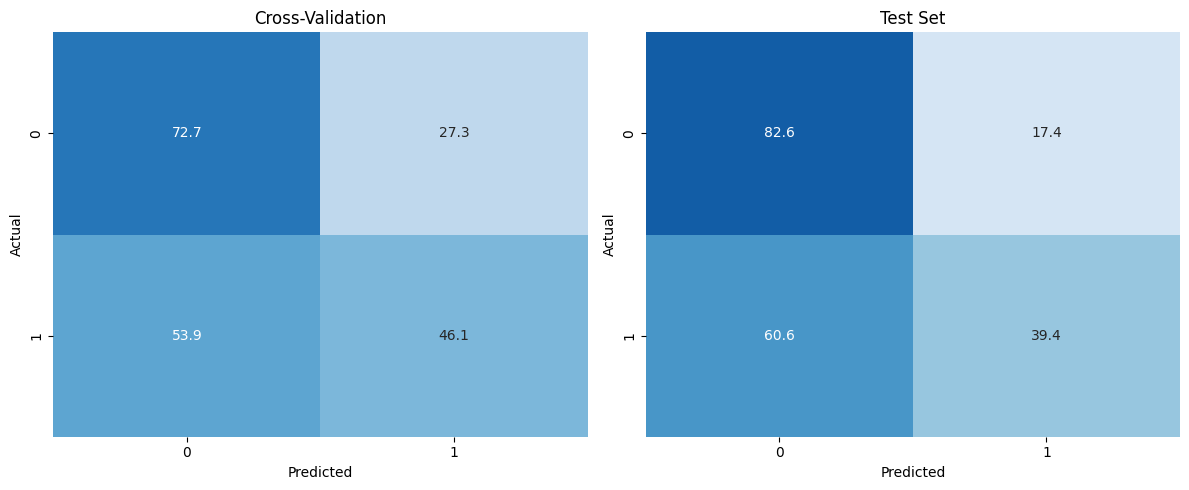

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np


# For binary, if probs are shape (n_samples,), for multi-class shape (n_samples, n_classes)
def to_labels(probs, threshold=0.5):
    if probs.ndim == 1 or probs.shape[1] == 1:  # Binary case
        return (probs >= threshold).astype(int)
    else:  # Multi-class case
        return np.argmax(probs, axis=1)

results = [
    ("Cross-Validation", pooled_true, to_labels(pooled_probs)),
    ("Test Set", y_true_test, to_labels(y_prob_test))
]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes = axes.flatten()

for ax, (title, y_true, y_pred) in zip(axes, results):
    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
    sns.heatmap(
        cm_percent, annot=True, fmt='.1f', cmap='Blues',
        ax=ax, vmin=0, vmax=100, cbar=False
    )
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()

